In [1]:
#Importing Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
#Importaing Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = CIFAR10(root='data/', download=True, transform=transform)
test_set = CIFAR10(root='data/', train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


# Data Analysis

In [3]:
#Inspecting training dataset
size_trainset = len(train_set)
print(f"Length of training dataset is {size_trainset}")

#Inspecting testing dataset
size_testset = len(test_set)
print(f"Length of testing dataset is {size_testset}")

Length of training dataset is 50000
Length of testing dataset is 10000


In [4]:
#Inspecting output classes
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
total_classes = len(classes)
print(f"Total number of output classes are {total_classes} ")

Total number of output classes are 10 


In [6]:
#Identifying shape of image tensor
image, label = train_set[0]
image_shape = image.shape
image_shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label id: 2
Label (corresponding text): bird


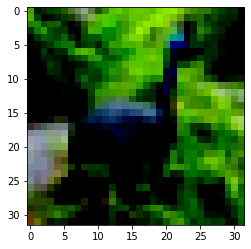

In [7]:
#As imshow expects images to be structured as (rows, columns, channels) values for RGB data
#We will rearrange original image tensor according to the desired ordering 
image, label = train_set[6]
plt.imshow(image.permute((1, 2, 0)))
print('Label id:', label)
print('Label (corresponding text):', classes[label])

# Preparing data for processing

In [8]:
#loading training data for ann in batches using DataLoader
#setting seed to 80 for generating random numbers
torch.manual_seed(80)
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=False)

# Building ANN Model

In [9]:
class ANN(nn.Module):
    #We need to flatten the input size before feeding it to neural network
    def __init__(self, input_size=3*32*32, output_size=10):
        super().__init__()
        self._to_linear = None    
        self.fc1 = nn.Linear(input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [10]:
#creating a variable "artificial_nn" to call ANN() class
torch.manual_seed(80)
ann = ANN()
ann

ANN(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)